In [1]:
import networkx as nx

In [448]:
import networkx as nx
GRAPHS = {'inf-power':"data/inf-power/inf-power.mtx",
          'protein':"data/protein/bio-yeast-protein-inter.edges",
          'erdos':"data/erdos/ca-Erdos992.mtx",
         'auto_as19990309':"data/as19990309.txt",
          'auto_as19990111':"data/as-733/as19990111.txt",
          'wiki':"data/wiki/soc-wiki-Vote.mtx",
         'norwegian': 'data/norwegian/net1m_2011-08-01.txt',
         'netscience':'data/dimacs10-netscience/out.dimacs10-netscience',
         'moreno_innovation':"data/moreno_innovation/out.moreno",
#          'inf_power':'data/inf-power/inf-power.mtx',
         'GrQc':'data/ca_GrQc/ca-GrQc.mtx',
         'auto_as19980318':'data/as19980318.txt',
         'auto_as19971108':'data/as19971108.txt',
         'tech_routers':'data/routers/tech-routers-rf.mtx',
         "ca_grq":"data/ca_GrQc/ca-GrQc.mtx",
         'oregon':"data/oregon_331/oregon1_010331.txt",
         'arena':"data/arenas-jazz/out.arenas-jazz",
         'moreno_oz':"data/moreno_oz/out.moreno_oz_ozcsv",  
         "hamsterer":"data/hamsterer/soc-hamsterster.edges",
          "openflights":"data/openflights/inf-openflights.edges",
          "tech_pgp":"data/pgp/tech-pgp.edges",
          'dmela':"data/dmela/bio-dmela.mtx",
          "whois":"data/WHOIS/tech-WHOIS.mtx",
          'webspam':"data/web-spam/web-spam.mtx",
          "gnutella08":"data/gnutalla08/p2p-Gnutella08.txt",
#           'notredame':"data/web-NotreDame.txt",
          'email_auall':"data/Email-EuAll.txt",
          'email_enron':"data/Email-Enron.txt",
          'musae_git':"data/git_web_ml/musae_git_edges.csv",
          'musae_facebook':"data/facebook_large/musae_facebook_edges.csv",
#           'fb_pages_artist':"data/fb-pages-artist/fb-pages-artist.edges",
#           'gowalla':"data/soc-gowalla/soc-gowalla.mtx",
#           'slashdot':"data/soc-slashdot/soc-slashdot.mtx",
          'ca-HepPh':'data/ca-HepPh.mtx' #+
         }

In [4]:
from networkx import pagerank

In [5]:

graph = nx.read_adjlist(GRAPHS['oregon'])

In [6]:
kcores = nx.core_number(graph)

In [7]:
from tqdm.notebook import tqdm, trange

# def kcores_pagerank(graph, kcores, alpha=0.85):
#     prob_importance = dict()
#     for k in set(kcores.values()):
#         personalization = dict()
#         for n,kn in kcores.items():
#             personalization[n] = int(k==kn)
#         prnk = pagerank(graph, alpha=alpha, personalization = personalization, weight = None)
#         prob_importance[k] = {k:0 for k in set(kcores.values())}

#         for n, kn in kcores.items():
#             prob_importance[k][kn]+=prnk[n]
#     return prob_importance

def kcores_orig(graph, kcores, alpha=0.85):
#     prob_importance = dict()
#     for k in set(kcores.values()):
    prob_importance = {k:{k2:0 for k2 in set(kcores.values())} for k in set(kcores.values())}
    personalization = dict()
    for u,v in graph.edges():
        prob_importance[kcores[v]][kcores[u]]+=1/graph.number_of_nodes()
        prob_importance[kcores[u]][kcores[v]]+=1/graph.number_of_nodes()
#         prnk = pagerank(graph, alpha=alpha, personalization = personalization, weight = None)
#         prob_importance[k] = {k:0 for k in set(kcores.values())}

#         for n, kn in kcores.items():

    return prob_importance

In [1]:
from itertools import product
#list(product(set(kcores.values()),set(kcores.values())))

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import product


def visualize_graph_orig(graph, node_scale=0.5, savepath = None, label = None, ax=None, edge_color='green'):
#     figure(figsize=(6, 5), dpi=80)
    if ax is None:
        fg, ax = plt.subplots()
    k_shells = nx.core_number(graph)
    kcores_p = kcores_orig(graph, k_shells)
    kcores_set = set(k_shells.values())
    ng_edges = {frozenset(x):0 for x in product(kcores_set,kcores_set)}#dict()
    for k, e in kcores_p.items():
        for k2, v in e.items():
            ng_edges[frozenset([k,k2])] += v
    new_graph = nx.Graph()
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_heur = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    if s!=0:
                        new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                        weights_heur[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
            if i<=j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color=edge_color, node_size=nds_size_list,ax=ax)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos, ax=ax)
    el = list(H.edges(data='weight'))
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color=edge_color,ax=ax)
    if label is not None:
        ax.title.set_text(label)
    if savepath is not None:
        plt.savefig(savepath)
#     plt.show()
    return weights_heur

In [12]:
from tqdm.notebook import tqdm, trange
from collections import Counter

def kcores_pagerank(graph, kcores, alpha=0.85, normalized = True):
    kcores_size = Counter(kcores.values())
    prob_importance = dict()
    for k in set(kcores.values()):
        personalization = dict()
        for n,kn in kcores.items():
            personalization[n] = int(k==kn)
        prnk = pagerank(graph, alpha=alpha, personalization = personalization, weight = None)
        prob_importance[k] = {k:0 for k in set(kcores.values())}

        for n, kn in kcores.items():
            if normalized:
                prob_importance[k][kn]+=prnk[n]/kcores_size[kn]
            else:
                prob_importance[k][kn]+=prnk[n]
    return prob_importance

In [13]:
import numpy as np
import random
from scipy.optimize import fixed_point, root


# def hr_edges(graph):
#     kcores = nx.core_number(graph)
#     cs = get_core_strengths(graph, kcores)
#     np, ps, gk = dict(), dict(), dict()
#     for n in graph.nodes():
#         np[n] = len([nbr for nbr in graph.neighbors(n) if cs[nbr]==1 and kcores[nbr]>=kcores[n]])
#         gk[n] = len([nbr for nbr in graph.neighbors(n) if kcores[n]>=kcores[nbr]])
#         try:
#             ps[n] = max((kcores[n]-np[n])/(gk[n]-np[n]),0)
#         except:
#             ps[n] = 1
#     edges_v = dict()
#     for e in graph.edges():
#         el = list(e)
#         if kcores[e[0]]>kcores[e[1]]:
#             edges_v[frozenset(e)] = ps[el[1]]
#         elif kcores[e[0]]<kcores[e[1]]:
#             edges_v[frozenset(e)] = ps[el[0]]
#         else:
#             edges_v[frozenset(e)] = max(ps[el[0]], ps[el[1]])
#     return edges_v

def get_core_strengths(graph:nx.Graph, core_numbers):
    cs = dict()
    for node in graph:
        bn = [ x for x in graph.neighbors(node) if core_numbers[x]>=core_numbers[node]]
        cs[node] = len(bn) - core_numbers[node]+1
    return cs

def get_prob_needed_fixed(graph:nx.Graph, core_numbers):
    cs_strengths = get_core_strengths(graph, core_numbers)
    cs = dict()
    for node in graph:
#         bn = [ x for x in graph.neighbors(node) if core_numbers[x]>=core_numbers[node]]
        bn = [ x for x in graph.neighbors(node) if core_numbers[x]>core_numbers[node] or
              (core_numbers[x]==core_numbers[node] and cs_strengths[x]>1)]
        bn_diff = [ x for x in graph.neighbors(node) if core_numbers[x]==core_numbers[node] and cs_strengths[x]==1]
        if len(bn) == 0:
            cs[node] = 1
        else:
            cs[node] = max((core_numbers[node]-len(bn_diff))/len(bn),0)
    return cs


def hr_edges(graph):
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    np, ps, gk = dict(), dict(), dict()
    edge_avg_cs = get_prob_needed_fixed(graph, kcores) #{frozenset(x):min(cs[x[0]],cs[x[1]]) for x in graph.edges()}
    edges_v = dict()
    for e in graph.edges():
        el = list(e)
        if kcores[e[0]]>kcores[e[1]]:
            edges_v[frozenset(e)] = edge_avg_cs[el[1]]
        elif kcores[e[0]]<kcores[e[1]]:
            edges_v[frozenset(e)] = edge_avg_cs[el[0]]
        else:
            edges_v[frozenset(e)] = max(edge_avg_cs[el[0]], edge_avg_cs[el[1]])
    return edges_v


def node_importance(T, A, A2, cs):
    return ((1-(cs/(A.dot((1-T).T)+A2.T+ cs)))-T)

def node_importance_adj(T, A, A2, cs, kkrs):
    cs_mask = cs==0
    cs_1 = cs.copy()
    cs_1[cs_mask] = 1
    cs_1[~cs_mask] = 0
    adj_prob = A2.T+A.dot(1-cs_1)-np.maximum(0, kkrs-A.T.dot(cs_1))
    return (1-(adj_prob/(A.dot((1-T).T)+A2.T+A.dot(1-cs_1)))-T)



def hr_edges_global(graph):
    kkrs = nx.core_number(graph)
    cs_strengths = np.array(list(get_core_strengths(graph, kkrs).values()))-1
    A = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    kkrs_numpy = np.array(list(kkrs.values()))
    for i in range(len(A)):
        A[i,kkrs_numpy!=kkrs_numpy[i]] = 0
        
    A2 = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    for i in range(len(A2)):
        A2[i,kkrs_numpy<=kkrs_numpy[i]] = 0
    A2 = A2.sum(axis=1)
    
    A_big = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    for i in range(len(A_big)):
        A_big[i,kkrs_numpy<kkrs_numpy[i]] = 0  
    ni = root(node_importance, np.zeros(graph.number_of_nodes()), args=(A,A2,cs_strengths),
    method = 'df-sane', tol = 0.00000000000001)
    prb_needed = {n:float(ni.x[i]) for i,n in enumerate(graph.nodes())}
    edges_v = dict()
    for e in graph.edges():
        el = list(e)
        if kkrs[e[0]]>kkrs[e[1]]:
            edges_v[frozenset(e)] = prb_needed[el[1]]
        elif kkrs[e[0]]<kkrs[e[1]]:
            edges_v[frozenset(e)] = prb_needed[el[0]]
        else:
            edges_v[frozenset(e)] = max(prb_needed[el[0]], prb_needed[el[1]])
    return edges_v


def visualize_graph_local(graph, node_scale=0.5, local=True, savepath = None, label = None, ax = None, edge_color='green'):
#     figure(figsize=(6, 5), dpi=80)
    k_shells = nx.core_number(graph)
    if ax is None:
        fg, ax = plt.subplots()
    if local:
        edges_imp = hr_edges(graph)
    else:
        edges_imp = hr_edges_global(graph)
    #sorted(list(set(k_shells.values())))
    ng_edges = dict()
    for u,v in graph.edges():
#         if k_shells[u]==25 or k_shells[v]==25:
#             print(u,v, k_shells[u],k_shells[v] )
        try:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] += edges_imp[frozenset([u,v])]
        except Exception as inst:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] = edges_imp[frozenset([u,v])]
    
    new_graph = nx.Graph()
    
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_heur = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    if s!=0:
                        new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                        weights_heur[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
#                     else:
#                         new_graph.add_edge(j,i, weight=1)
            if i<j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color=edge_color, node_size=nds_size_list, ax=ax)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos, ax=ax)
    el = list(H.edges(data='weight'))
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color=edge_color, ax=ax)
#     for edge in tqdm(H.edges(data='weight')):
#         if edge[0]!=edge[1] and edge[2]!=0:
#             wdth = edge[2]*4
#             nx.draw_networkx_edges(H, pos, edgelist=[edge], width=wdth, edge_color='green')
    if label is not None:
        ax.title.set_text(label)
#     if savepath is not None:
#         plt.savefig(savepath)
#     plt.show()
    return weights_heur

In [14]:
def visualize_graph(graph, p=0.85, node_scale=0.5, savepath = None, label = None, ax = None, edge_color='green', normalized=True):
    if ax is None:
        fg, ax = plt.subplots()
#     figure(figsize=(6, 5), dpi=80)
    k_shells = nx.core_number(graph)
    kcores_p = kcores_pagerank(graph, k_shells, p, normalized=normalized)
    kcores_set = set(k_shells.values())
    ng_edges = {frozenset(x):0 for x in product(kcores_set,kcores_set)}#dict()
    for k, e in kcores_p.items():
        for k2, v in e.items():
            ng_edges[frozenset([k,k2])] += v
    new_graph = nx.Graph()
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_heur = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    if s!=0:
                        new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                        weights_heur[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
            if i<=j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color=edge_color, node_size=nds_size_list, ax=ax)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos,ax=ax)
    el = list(H.edges(data='weight'))
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color=edge_color, ax=ax)
    if label is not None:
        ax.title.set_text(label)
#     if savepath is not None:
#         plt.savefig(savepath)
#     plt.show()
    return weights_heur

In [15]:
visualize_graph_orig(graph)

{frozenset({17}): 0.03669280666085699,
 frozenset({16}): 0.007117437722419925,
 frozenset({16, 17}): 0.3309608540925268,
 frozenset({15}): 0.0,
 frozenset({15, 16}): 0.007843137254901952,
 frozenset({15, 17}): 0.3450980392156863,
 frozenset({14}): 0.06583302684810573,
 frozenset({14, 15}): 0.005516734093416693,
 frozenset({14, 16}): 0.0022066936373666777,
 frozenset({14, 17}): 0.1213681500551667,
 frozenset({13}): 0.0,
 frozenset({13, 14}): 0.17894736842105255,
 frozenset({13, 15}): 0.0,
 frozenset({13, 16}): 0.0,
 frozenset({13, 17}): 0.36842105263157915,
 frozenset({12}): 0.01068376068376068,
 frozenset({12, 13}): 0.0,
 frozenset({12, 14}): 0.09188034188034196,
 frozenset({12, 15}): 0.0,
 frozenset({12, 16}): 0.01068376068376068,
 frozenset({12, 17}): 0.2670940170940167,
 frozenset({11}): 0.002024291497975708,
 frozenset({11, 12}): 0.002024291497975708,
 frozenset({11, 13}): 0.0,
 frozenset({11, 14}): 0.07894736842105271,
 frozenset({11, 15}): 0.004048582995951416,
 frozenset({11, 16

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def plot_image(path):
    figure(figsize=(8, 7.5), dpi=80)
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [19]:
def orig_edges(graph):
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    ev = dict()
    for u,v in graph.edges():
        if kcores[u]!=kcores[v]:
            if kcores[u]>kcores[v]:
                u,v = v,u
            ev[frozenset([u,v])] = kcores[u]/len([n for n in graph.neighbors(u) if kcores[n]>=kcores[u]])
        else:
            ev[frozenset([u,v])] = (kcores[u]/len([n for n in graph.neighbors(u) if kcores[n]>=kcores[v]]))*kcores[v]/len([n for n in graph.neighbors(v) if kcores[n]>=kcores[v]])
        # k[u]<k[v]
    return ev

def get_centralized_score(graph, orig = False):
    ce = 0
    kcores = nx.core_number(graph)
    hk = max(kcores.values())
    if orig:
        eimp = orig_edges(graph)
    else:
        eimp = hr_edges(graph)
    for n in graph.nodes():
        e = 0
        nbrs = [nbr for nbr in graph.neighbors(n) if kcores[nbr]>=kcores[n]]
        for nbr in nbrs:
            try:
                e+=eimp[frozenset([nbr,n])]*((kcores[nbr]-kcores[n])/(hk - kcores[n]))
            except:
                pass
        ce+=e/len(nbrs)
    ce/=graph.number_of_nodes()
    return ce

In [22]:
import pandas as pd
graph_list = ['GrQc',"erdos",'inf-power','auto_as19990309','auto_as19971108','wiki','oregon','tech_routers',
             "hamsterer","openflights","tech_pgp","dmela","whois","webspam","gnutella08"]
df_ce = pd.DataFrame()

ce_l, ce_orig = [], []
for gr_name in graph_list:
#     fig, axs = plt.subplots(2,5, figsize=(22, 8), dpi=80)
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    print(gr_name, get_centralized_score(graph), get_centralized_score(graph, True))
    ce_l.append(get_centralized_score(graph))
    ce_orig.append(get_centralized_score(graph, True))
df_ce['gr_name'] = graph_list
df_ce['ce_orig'] = ce_orig
df_ce['ce_new'] = ce_l
df_ce.head()

GrQc 0.04316818482601314 0.044641463473098913
erdos 0.3670184124816461 0.36833343706533356
inf-power 0.05699650853617658 0.0594082967320552
auto_as19990309 0.4769980775481666 0.4828665522987709
auto_as19971108 0.5133621889388745 0.5208615732786899
wiki 0.35881755451212455 0.3653798924951621
oregon 0.5560402135072096 0.5602111029824178
tech_routers 0.24263719702606715 0.24787067170277507
hamsterer 0.2652066620180222 0.2687182765166311
openflights 0.41246857636832784 0.41660623384096807
tech_pgp 0.068175210226669 0.07077203475566551
dmela 0.44897369161614226 0.45488616553325556
whois 0.3461889904009918 0.34803209916316286
webspam 0.38507898453211986 0.38765300070501313
gnutella08 0.24731659117450083 0.24906923329045977


gr_name   ce_orig    ce_new
0             GrQc  0.044641  0.043168
1            erdos  0.368333  0.367018
2        inf-power  0.059408  0.056997
3  auto_as19990309  0.482867  0.476998
4  auto_as19971108  0.520862  0.513362

In [23]:
kcore_res = {'GrQc':0.75,'inf-power':0.49,"auto_as19990309":0.62,"auto_as19971108":0.58,'wiki':0.76,'erdos':0.69,
            'oregon':0.66,'tech_routers':0.83,"hamsterer":0.84,"openflights":0.87,"tech_pgp":0.81,"dmela":0.80,
            'whois':0.89,"webspam":0.87,'gnutella08':0.73}

In [24]:
df_ce['kres'] = df_ce['gr_name'].apply(lambda x:kcore_res.get(x,0))
df_ce = df_ce[df_ce['kres']!=0].reset_index(drop=True)
df_ce

gr_name   ce_orig    ce_new  kres
0              GrQc  0.044641  0.043168  0.75
1             erdos  0.368333  0.367018  0.69
2         inf-power  0.059408  0.056997  0.49
3   auto_as19990309  0.482867  0.476998  0.62
4   auto_as19971108  0.520862  0.513362  0.58
5              wiki  0.365380  0.358818  0.76
6            oregon  0.560211  0.556040  0.66
7      tech_routers  0.247871  0.242637  0.83
8         hamsterer  0.268718  0.265207  0.84
9       openflights  0.416606  0.412469  0.87
10         tech_pgp  0.070772  0.068175  0.81
11            dmela  0.454886  0.448974  0.80
12            whois  0.348032  0.346189  0.89
13          webspam  0.387653  0.385079  0.87
14       gnutella08  0.249069  0.247317  0.73

In [27]:
# ys = df_ce['ce_orig']
# xs = df_ce['kres']
# plt.scatter(xs, ys)
import random
import scipy.stats as stats

def kcore_resilience(graph_orig, trials_num, perc = 0.05):
    kcores = nx.core_number(graph_orig)
    res = []
    for e in range(trials_num):
        graph = graph_orig.copy()
        num2rem = int(graph.number_of_edges()*perc)
        graph.remove_edges_from(random.sample(list(graph.edges()), num2rem))
        kcores_new = nx.core_number(graph)
        res.append(stats.kendalltau([kcores[n] for n in graph.nodes()],[kcores_new[n] for n in graph.nodes()]))
    return np.mean(res)

In [28]:
import pandas as pd
graph_list = ['GrQc',"erdos",'inf-power','auto_as19990309','auto_as19971108','wiki','oregon','tech_routers',
             "hamsterer","openflights","tech_pgp","dmela","whois","webspam","gnutella08"]
df_ce = pd.DataFrame()
ce_orig, ce_l = [],[]
kres = []
exclude = {'erdos','inf-power','dmela','gnutella08','wiki','GrQc','hamsterer','openflights','auto_as19990309'}
for gr_name in graph_list:
    if gr_name in exclude:
        continue
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    kres.append(kcore_resilience(nx.k_core(graph, max(nx.core_number(graph).values())-5),10))
    ce_orig.append(get_centralized_score(graph, True))
    ce_l.append(get_centralized_score(graph))
df_ce['gr_name'] = [g for g in graph_list if g not in exclude]
df_ce['ce_orig'] = ce_orig
df_ce['ce_new'] = ce_l    
df_ce['kres'] = kres
df_ce.head()

gr_name   ce_orig    ce_new      kres
0  auto_as19971108  0.520862  0.513362  0.451892
1           oregon  0.560211  0.556040  0.454917
2     tech_routers  0.247871  0.242637  0.414168
3         tech_pgp  0.070772  0.068175  0.439225
4            whois  0.348032  0.346189  0.308213

In [29]:
exclude = {'erdos','inf-power','dmela','gnutella08','wiki','GrQc','hamsterer','openflights','auto_as19990309'}
for gr_name in graph_list:
    if gr_name in exclude:
        continue
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    kcores = nx.core_number(graph)
    mx_k = max(kcores.values())
    
    print(nx.k_core(graph, mx_k-5).number_of_nodes(),gr_name, mx_k)

156 auto_as19971108 9
103 oregon 17
136 tech_routers 15
124 tech_pgp 31
129 whois 88
126 webspam 35


In [31]:
from random import choice, shuffle

def get_greedy_minimal_choice(original_graph:nx.Graph):
    graph = original_graph.copy()
#     graph_nodes = list(graph.nodes())
#     shuffle(graph_nodes)
#     mapping = dict()
#     for i,n in enumerate(graph_nodes):
#         mapping[n] = i
#     graph = nx.relabel_nodes(graph, mapping)
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    while not test_minimal(graph, kcores):
        edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)]
        edge_rem = choice(edge_candidates) #[0]
        graph.remove_edge(*edge_rem)
        cs = get_core_strengths(graph, kcores)
    return graph

In [32]:
import math

def test_minimal(graph:nx.Graph, core_numbers):
#     assert nx.core_number(graph)==core_numbers
#     if (nx.core_number(graph)!=core_numbers):
#         return False
    cs = get_core_strengths(graph, core_numbers)
    edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (core_numbers[u]==core_numbers[v] and cs[u]>1 and cs[v]>1)
                           or (core_numbers[u]>core_numbers[v] and cs[v]>1) or (core_numbers[u]<core_numbers[v] and cs[u]>1)]
    return len(edge_candidates)==0

# problem that transition graph is not a tree, hence we cannot claim that our computations are representative
def knuth_counting(graph_orig):
    graph = graph_orig.copy()
    k = 0
    D = 0
#     C = 1
    kcores = nx.core_number(graph)
    s_len = []
    cs = get_core_strengths(graph, kcores)
    edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)]
    while len(edge_candidates)!=0:
        s = len(edge_candidates)
        s_len.append(s)
        edge_rem = choice(edge_candidates) #[0]
        graph.remove_edge(*edge_rem)
        D+=math.log(s)
        cs = get_core_strengths(graph, kcores)
        edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)]
    assert(nx.core_number(graph)==kcores)
    return D-math.log(math.factorial(len(s_len))), graph_orig.number_of_edges()-len(s_len)

In [33]:
from typing import Set, List
import graph_tool.all as gt

def get_graphtools_graph(g:nx.Graph, only_from_nodes:Set = set()):
    g = nx.convert_node_labels_to_integers(g)
    graph = gt.Graph(directed=False)
    graph.set_fast_edge_removal(True)
    graph.vertex_properties["node"] = graph.new_vertex_property("object")
    # for n in self.nodes_set:
    #     graph.add_edge_list([(n,n2) for n2 in self.get_connections(n)])
    if len(only_from_nodes)!=0:
        processed = set(self.nodes).difference(only_from_nodes)
    else:
        processed = set()
    edge_list = []
    
    for n in g.nodes():
        for c in g.neighbors(n):
            if c not in processed:
                edge_list.append((int(n), int(c)))
                graph.vertex_properties["node"][c] = c
            graph.vertex_properties["node"][n] = n
        processed.add(n)
    graph.add_edge_list(edge_list)
    # for n in self.nodes:
    #     for c in self.get_connections(n):
    #         if c not in processed:
    #             graph.add_edge(n, c)
    #             graph.vertex_properties["node"][c] = c
    #         graph.vertex_properties["node"][n] = n

    return graph

In [36]:
def knuth_counting_fast(graph_orig):
    k = 0
    D = 0
#     C = 1
    graph = graph_orig.copy()
    kcores = nx.core_number(graph)
    s_len = []
    cs = get_core_strengths(graph, kcores)
    edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)]
    while len(edge_candidates)!=0:
        s = len(edge_candidates)
        s_len.append(s)
        edge_rem = choice(edge_candidates) #[0]
        graph.remove_edge(*edge_rem)
        D+=math.log(s)
        cs = get_core_strengths(graph, kcores)
        edge_candidates = [(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)]
    assert(nx.core_number(graph)==kcores)
    return D-math.log(math.factorial(len(s_len))), graph_orig.number_of_edges()-len(s_len)


# class ListDict(object):
#     def __init__(self):
#         self.item_to_position = {}
#         self.items = []

#     def add_item(self, item):
#         if item in self.item_to_position:
#             return
#         self.items.append(item)
#         self.item_to_position[item] = len(self.items)-1

#     def remove_item(self, item):
#         position = self.item_to_position.pop(item)
#         last_item = self.items.pop()
#         if position != len(self.items):
#             self.items[position] = last_item
#             self.item_to_position[last_item] = position

#     def choose_random_item(self):
#         return random.choice(self.items)

def knuth_counting_fast2(graph_orig):
    k = 0
    D = 0
#     C = 1
    graph = graph_orig.copy()
    kcores = nx.core_number(graph)
    s_len = []
    cs = get_core_strengths(graph, kcores)
    edge_candidates = set([(u,v) for u,v in graph.edges() if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)])
    while len(edge_candidates)!=0:
        s = len(edge_candidates)
        s_len.append(s)
        edge_rem = choice(list(edge_candidates)) #[0]
        graph.remove_edge(*edge_rem)
        edge_candidates.remove(edge_rem)
        D+=math.log(s)
#         cs = get_core_strengths(graph, kcores)
        u1, v1 = edge_rem
        if kcores[v1]==kcores[u1]:
            cs[v1]-=1
            cs[u1]-=1
        elif kcores[v1]>kcores[u1]:
            cs[u1]-=1
        elif kcores[v1]<kcores[u1]:
            cs[v1]-=1
        edge_candidates = {(u,v) for u,v in edge_candidates if 
                           (kcores[u]==kcores[v] and cs[u]>1 and cs[v]>1)
                           or (kcores[u]>kcores[v] and cs[v]>1) or (kcores[u]<kcores[v] and cs[u]>1)}
    assert(nx.core_number(graph)==kcores)
    return D-math.log(math.factorial(len(s_len))), graph_orig.number_of_edges()-len(s_len)

In [39]:

from tqdm.notebook import trange
from tqdm.contrib.concurrent import process_map

def smoothmax(c_list):
    if len(c_list)==2:
        x,y = c_list
        return x+math.log(1+math.exp(y-x))
    else:
        x = c_list[0]
        y = c_list[1:]
        return x+math.log(1+math.exp(smoothmax(y)-x))

def mt_knuth_counting(graph_orig, trials_num):
    estimates = []
    sizes = []
#     kcores = nx.core_number(graph_orig)
    graphs = [graph_orig.copy() for i in range(trials_num)]
    res = process_map(knuth_counting_fast2, graphs, max_workers=8, chunksize=5)
    estimates = [x[0] for x in res]
    sizes = [x[1] for x in res]
#     for i in trange(trials_num):
#         estim, size = knuth_counting_fast(graph)
#         estimates.append(estim)
#         sizes.append(size)
#     avg_est = np.mean(estimates)
#     avg_est = math.log(np.mean([math.exp(e) for e in estimates]))
    avg_est = smoothmax(estimates)-math.log(len(estimates))
#     print(avg_est, avg_est2)
    adj_size = np.mean([s*math.exp(estimates[i]-avg_est) for i,s in enumerate(sizes)])
#     adj_size2 = np.sum([s*math.exp(estimates[i]-avg_est) for i,s in enumerate(sizes)])
    return avg_est, np.mean(sizes), adj_size

In [396]:
gr_name_list = []
vertices_num = []
edges_num = []
k_cores_highest = []

for gr_name in list(tqdm(GRAPHS.keys())):
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    gr_name_list.append(gr_name)
    vertices_num.append(graph.number_of_nodes())
    edges_num.append(graph.number_of_edges())
    k_cores_highest.append(max(nx.core_number(graph).values()))

df_list = pd.DataFrame()
df_list['Network'] = gr_name_list
df_list['|V|'] = vertices_num
df_list['|E|'] = edges_num
df_list['Highest k-core'] = k_cores_highest

df_list

  0%|          | 0/29 [00:00<?, ?it/s]

Network     |V|     |E|  Highest k-core
0           inf-power    4941    6594               5
1             protein    1870    2203               5
2               erdos    5094    7515               7
3     auto_as19990309    4759    8896              12
4     auto_as19990111     549    1249              11
5                wiki     889    2914               9
6           norwegian    1421    3855              11
7          netscience    1461    2742              19
8   moreno_innovation     241     923               6
9                GrQc    4158   13422              43
10    auto_as19980318    3455    6168              10
11    auto_as19971108    3015    5156               9
12       tech_routers    2113    6632              15
13             ca_grq    4158   13422              43
14             oregon   10670   22002              17
15              arena     198    2742              29
16          moreno_oz     217    2345              14
17          hamsterer    2426   16630              24
18        openflights    2939   15677              28
19           tech_pgp   10680   24316              31
20              dmela    7393   25569              11
21              whois    7476   56943              88
22            webspam    4767   37375              35
23         gnutella08    6301   20777              10
24        email_auall  265214  364481              37
25        email_enron   36692  183831              43
26          musae_git   37700  289003              34
27     musae_facebook   22470  170823              56
28           ca-HepPh   11204  117619             238

In [44]:
df_ce2 = pd.DataFrame()
ce_orig2, ce_l2 = [],[]
kres2 = []
estimates = []
gr_list2 = []
sizes = []
adj_sizes = []
# adj_sizes2 = []
for gr_name in reversed(list(GRAPHS.keys())):#['norwegian','moreno_oz','arena','moreno_innovation','GrQc','netscience',"erdos",'inf-power','protein','auto_as19990309','auto_as19990111','auto_as19980318','auto_as19971108','wiki']:
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
#     print(graph.number_of_edges())
#     if graph.number_of_edges()>2500:
#         continue
    gr_list2.append(gr_name)
#     kres2.append(kcore_resilience(nx.k_core(graph, max(nx.core_number(graph).values())-5),10))
#     estimate = mt_knuth_counting(nx.k_core(graph, max(nx.core_number(graph).values())-5),50)
    estimate, size, adj_size = mt_knuth_counting(graph, 50)
    print(gr_name,estimate, size, adj_size)
    estimates.append(estimate)
    sizes.append(size)
    adj_sizes.append(adj_size)
#     adj_sizes2.append(adj_size2)
    try:
        ce_orig2.append(get_centralized_score(graph, True))
    except:
        ce_orig2.append(0)
    try: 
        ce_l2.append(get_centralized_score(graph))
    except:
        ce_l2.append(0)
df_ce2['gr_name'] = gr_list2
df_ce2['ce_orig'] = ce_orig2
df_ce2['ce_new'] = ce_l2
df_ce2['est'] = estimates
df_ce2['est_size'] = sizes
df_ce2['adj_size'] = adj_sizes
# df_ce2['kres'] = kres2
df_ce2.head()

  0%|          | 0/50 [00:00<?, ?it/s]

ca-HepPh 7238.80050491993 110925.36 110916.63190151565


  0%|          | 0/50 [00:01<?, ?it/s]

musae_facebook 20733.9442866751 151252.68 151262.00000007421


  0%|          | 0/50 [00:04<?, ?it/s]

musae_git 19232.564119562532 275978.28 275969.0000001354


  0%|          | 0/50 [00:01<?, ?it/s]

email_enron 12057.627605231766 171981.9 172006.00000008437


  0%|          | 0/50 [00:03<?, ?it/s]

email_auall 5748.6923414770135 358501.2 358507.83664923324


  0%|          | 0/50 [00:00<?, ?it/s]

gnutella08 2853.35582051247 16312.62 16346.999999002426


  0%|          | 0/50 [00:00<?, ?it/s]

webspam 3861.3860299658295 34310.94 34325.99888515278


  0%|          | 0/50 [00:00<?, ?it/s]

whois 7113.978673342893 52131.08 52113.04407920407


  0%|          | 0/50 [00:00<?, ?it/s]

dmela 2901.083745788953 22473.52 22473.000041194646


  0%|          | 0/50 [00:00<?, ?it/s]

tech_pgp 2051.172158064589 20578.24 20589.999605097215


  0%|          | 0/50 [00:00<?, ?it/s]

openflights 1443.451889776678 14177.14 14173.937030055338


  0%|          | 0/50 [00:00<?, ?it/s]

hamsterer 2088.623618822571 14871.7 14882.999999984257


  0%|          | 0/50 [00:00<?, ?it/s]

moreno_oz 537.9655940326537 1883.94 1880.801899759347


  0%|          | 0/50 [00:00<?, ?it/s]

arena 454.89232342792144 2297.3 2297.585629523023


  0%|          | 0/50 [00:00<?, ?it/s]

oregon 630.5177881398178 20810.86 20811.367651390443


  0%|          | 0/50 [00:00<?, ?it/s]

ca_grq 699.7163526883376 11926.54 11929.41000705254


  0%|          | 0/50 [00:00<?, ?it/s]

tech_routers 645.6532915860166 5730.02 5734.0115496708395


  0%|          | 0/50 [00:00<?, ?it/s]

auto_as19971108 161.16145105090146 4717.1 4724.985297015696


  0%|          | 0/50 [00:00<?, ?it/s]

auto_as19980318 212.50698761819476 5649.18 5648.128129239494


  0%|          | 0/50 [00:00<?, ?it/s]

GrQc 711.8567301252078 11927.22 11931.999999819705


  0%|          | 0/50 [00:00<?, ?it/s]

moreno_innovation 142.75853366232198 746.06 750.9664198521178


  0%|          | 0/50 [00:00<?, ?it/s]

netscience 40.197008118014544 2626.42 2628.1306775848793


  0%|          | 0/50 [00:00<?, ?it/s]

norwegian 43.912989647314525 3656.98 3659.983845779059


  0%|          | 0/50 [00:00<?, ?it/s]

wiki 371.60668637579244 2465.42 2472.1257729152217


  0%|          | 0/50 [00:00<?, ?it/s]

auto_as19990111 60.28259836137982 1130.46 1130.2553774710627


  0%|          | 0/50 [00:00<?, ?it/s]

auto_as19990309 266.0902494800987 8271.8 8269.032530017465


  0%|          | 0/50 [00:00<?, ?it/s]

erdos 312.49533021549115 6864.3 6871.992568944294


  0%|          | 0/50 [00:00<?, ?it/s]

protein 125.0426973640791 1815.76 1816.999294243258


  0%|          | 0/50 [00:00<?, ?it/s]

inf-power 406.2622337820846 5285.9 5288.076376717337


gr_name   ce_orig    ce_new           est   est_size       adj_size
0        ca-HepPh  0.072451  0.071304   7238.800505  110925.36  110916.631902
1  musae_facebook  0.116561  0.115477  20733.944287  151252.68  151262.000000
2       musae_git  0.590154  0.587753  19232.564120  275978.28  275969.000000
3     email_enron  0.446398  0.443165  12057.627605  171981.90  172006.000000
4     email_auall  0.000000  0.000000   5748.692341  358501.20  358507.836649

In [289]:
# df_ce2.to_csv('skeletal_kcore_counting_all.csv')
# df_ce2 = pd.read_csv('skeletal_kcore_counting2.csv', index_col=0)
# df_ce2.to_csv('all_graphs_est_size.csv')
# df_ce2 = pd.read_csv('kres_graphlist.csv', index_col=0)
# df_ce2.to_csv('all_graphs_est_size_more_graphs.csv')#, index_col=0)
df_ce2 = pd.read_csv('all_graphs_est_size_more_graphs.csv', index_col=0)

In [533]:
df_ce3[['kres','gr_name']].to_csv('kres_full.csv')

In [292]:
# df_ce2.to_csv('skeletal_kcore_counting1.csv')
# df_ce2 = pd.read_csv('skeletal_kcore_counting1.csv', index_col=0)
df_ce2

gr_name   ce_orig    ce_new           est   est_size  \
0            ca-HepPh  0.072451  0.071304   7238.800505  110925.36   
1      musae_facebook  0.116561  0.115477  20733.944287  151252.68   
2           musae_git  0.590154  0.587753  19232.564120  275978.28   
3         email_enron  0.446398  0.443165  12057.627605  171981.90   
4         email_auall  0.000000  0.000000   5748.692341  358501.20   
5          gnutella08  0.249069  0.247317   2853.355821   16312.62   
6             webspam  0.387653  0.385079   3861.386030   34310.94   
7               whois  0.348032  0.346189   7113.978673   52131.08   
8               dmela  0.454886  0.448974   2901.083746   22473.52   
9            tech_pgp  0.070772  0.068175   2051.172158   20578.24   
10        openflights  0.416606  0.412469   1443.451890   14177.14   
11          hamsterer  0.268718  0.265207   2088.623619   14871.70   
12          moreno_oz  0.337420  0.334642    537.965594    1883.94   
13              arena  0.217055  0.215752    454.892323    2297.30   
14             oregon  0.560211  0.556040    630.517788   20810.86   
15             ca_grq  0.044641  0.043168    699.716353   11926.54   
16       tech_routers  0.247871  0.242637    645.653292    5730.02   
17    auto_as19971108  0.520862  0.513362    161.161451    4717.10   
18    auto_as19980318  0.506315  0.499118    212.506988    5649.18   
19               GrQc  0.044641  0.043168    711.856730   11927.22   
20  moreno_innovation  0.241120  0.236528    142.758534     746.06   
21         netscience  0.021539  0.020995     40.197008    2626.42   
22          norwegian  0.032970  0.030960     43.912990    3656.98   
23               wiki  0.365380  0.358818    371.606686    2465.42   
24    auto_as19990111  0.464807  0.453553     60.282598    1130.46   
25    auto_as19990309  0.482867  0.476998    266.090249    8271.80   
26              erdos  0.368333  0.367018    312.495330    6864.30   
27            protein  0.000000  0.000000    125.042697    1815.76   
28          inf-power  0.059408  0.056997    406.262234    5285.90   

         adj_size  
0   110916.631902  
1   151262.000000  
2   275969.000000  
3   172006.000000  
4   358507.836649  
5    16346.999999  
6    34325.998885  
7    52113.044079  
8    22473.000041  
9    20589.999605  
10   14173.937030  
11   14883.000000  
12    1880.801900  
13    2297.585630  
14   20811.367651  
15   11929.410007  
16    5734.011550  
17    4724.985297  
18    5648.128129  
19   11932.000000  
20     750.966420  
21    2628.130678  
22    3659.983846  
23    2472.125773  
24    1130.255377  
25    8269.032530  
26    6871.992569  
27    1816.999294  
28    5288.076377

In [293]:
# nodes_subgraph_centrality = nx.subgraph_centrality(graph)

In [294]:
e_pow = []
graph_nodes = []
for gr_name in df_ce2['gr_name']:
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    e_pow.append(graph.number_of_edges())
    graph_nodes.append(graph.number_of_nodes())
#     e_pow.append(nx.k_core(graph, max(nx.core_number(graph).values())-5).number_of_edges())

In [295]:
# df_ce2['est'] = estimates
df_ce2['edges'] = e_pow
df_ce2['nodes'] = graph_nodes
# df_ce2['est_norm'] = df_ce2['est']/df_ce2['edges']
# df_ce2


In [457]:
import math
# n!/(r!(n-r)!)

def get_upper_bound(en, total_e):
    result = 0
    for i in range(1, total_e+1):
        result+=math.log(i)
    for i in range(1, en+1):
        result-=math.log(i)
    for i in range(1, total_e-en+1):
        result-=math.log(i)
    return result

# df_ce2['est_norm'] = df_ce2.apply(lambda r:get_upper_bound(int(r['est_size']),int(r['edges'])), axis=1)
# df_ce2['est_norm']
df_ce2['est_norm2'] = df_ce2.apply(lambda r:get_upper_bound(int(r['adj_size']),int(r['edges'])), axis=1)
# df_ce3['est_norm2'] = df_ce3.apply(lambda r:/(int(r['removable']), axis=1)
df_ce2['est_norm'] = df_ce2['est']/df_ce2['est_norm2']

0     25681.103068
1     60800.755700
2     53093.198560
3     43943.023324
4     30503.536174
5     10806.899231
6     10596.276491
7     16487.736660
8      9432.119977
9     10429.485483
10     4941.402894
11     5609.436465
12     1159.796878
13     1212.055551
14     4629.955218
15     4687.205061
16     2632.958092
17     1497.279933
18     1777.166264
19     4685.129051
20      447.736929
21      477.127034
22      780.033909
23     1248.337891
24      389.648808
25     2258.163715
26     2210.280036
27     1021.614665
28     3281.625425
Name: est_norm, dtype: float64

In [ ]:
df_ce3 = df_ce2.copy() #.iloc[1:].copy()
df_ce3['kres_orig'] = df_ce3['gr_name'].apply(lambda x:kcore_res.get(x,0))
# df_ce3['est_norm'] = df_ce3['est']/df_ce3['est_size']

df_ce3 = df_ce3[df_ce3['gr_name']!="moreno_oz"]
df_ce3

In [298]:
from tqdm.contrib.concurrent import process_map
import random

# res = process_map(knuth_counting_fast, graphs, max_workers=8)

def kcore_res_subroutine(params):
#     graph_orig, kcores, nodes_of_interest, num2rem, trials_num = params
    graph_orig, kcores_of_interest, nodes_of_interest, num2rem, trials_num = params
    res_for_num = []
    for e in range(trials_num):
#         e_set = set([frozenset(e) for e in graph_orig.edges()])
#         e_set = [list(e) for e in e_set]
        graph = graph_orig.copy()
#         edges2rem = []
#         for j in range(num2rem):
# #             random.shuffle(e_set)
#             u,v = random.sample(list(graph.edges()),1)[0]
#             graph.remove_edge(u,v)
#             edges2rem.append(e_set.pop(random.randint(0, len(e_set)-1)))
        graph.remove_edges_from(random.sample(list(graph.edges()), num2rem))
#         graph.remove_edges_from(edges2rem)
        kcores_new = nx.core_number(graph)
        res_for_num.append(stats.kendalltau(kcores_of_interest,[kcores_new[n] for n in nodes_of_interest]).correlation)
    return np.mean(res_for_num)


def kcore_resilience_r(graph_orig, trials_num=1, nodes_perc=0.5, p1=0, p2=0.5):
    kcores = nx.core_number(graph_orig)
    res = []
    nodes_of_interest = [k for k,v in sorted(kcores.items(), key=lambda x:x[1], reverse=True)][:math.ceil(graph_orig.number_of_nodes()*nodes_perc)]
    kcores_of_interest = [kcores[n] for n in nodes_of_interest]
    mx_num2rem = math.ceil(graph_orig.number_of_edges()*p2)
    mn_num2rem = math.ceil(graph_orig.number_of_edges()*p1)
    params = [(graph, kcores_of_interest, nodes_of_interest, en, trials_num) for en in range(mn_num2rem, mx_num2rem+1)]
    res = process_map(kcore_res_subroutine, params, max_workers=16, chunksize=64)
#     for num2rem in trange(mn_num2rem, mx_num2rem):
#         res_for_num = []
#         for e in range(trials_num):
#             graph = graph_orig.copy()
#             graph.remove_edges_from(random.sample(list(graph.edges()), num2rem))
#             kcores_new = nx.core_number(graph)
#             res_for_num.append(stats.kendalltau([kcores[n] for n in nodes_of_interest],[kcores_new[n] for n in nodes_of_interest]).correlation)
#         res.append(np.mean(res_for_num))
    return np.mean(res), res

In [363]:
import numpy as np
from numpy import array, asarray, ma
from numpy.lib import NumpyVersion
from numpy.testing import suppress_warnings

from scipy.spatial.distance import cdist
# from scipy.ndimage import _measurements
# from scipy._lib._util import (check_random_state, MapWrapper,
#                               rng_integers, _rename_parameter, _contains_nan)

import scipy.special as special
from scipy import linalg
from scipy.stats._stats import _kendall_dis

def count_rank_tie_sep(ranks):
    ranks = np.asarray(ranks).ravel()
    cnt = np.bincount(ranks).astype('int64', copy=False)
    cnt = cnt[cnt > 1]
    return ((cnt * (cnt - 1) // 2).sum(),
            (cnt * (cnt - 1.) * (cnt - 2)).sum(),
            (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

def kendalltau(x, y, xtie, initial_lexsort=None, nan_policy='propagate',
               method='auto', variant='b', alternative='two-sided'):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    # check both x and y
#     cnx, npx = _contains_nan(x, nan_policy)
#     cny, npy = _contains_nan(y, nan_policy)
#     contains_nan = cnx or cny
#     if contains_nan:
#         raise ValueError("NAN somewhere!")

    def count_rank_tie(ranks):
        cnt = np.bincount(ranks).astype('int64', copy=False)
        cnt = cnt[cnt > 1]
        return ((cnt * (cnt - 1) // 2).sum(),
                (cnt * (cnt - 1.) * (cnt - 2)).sum(),
                (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

    size = x.size
    perm = np.argsort(y)  # sort on y and convert y to dense ranks
    x, y = x[perm], y[perm]
    y = np.r_[True, y[1:] != y[:-1]].cumsum(dtype=np.intp)

    # stable sort on x and convert x to dense ranks
    perm = np.argsort(x, kind='mergesort')
    x, y = x[perm], y[perm]
    x = np.r_[True, x[1:] != x[:-1]].cumsum(dtype=np.intp)

    dis = _kendall_dis(x, y)  # discordant pairs

    obs = np.r_[True, (x[1:] != x[:-1]) | (y[1:] != y[:-1]), True]
    cnt = np.diff(np.nonzero(obs)[0]).astype('int64', copy=False)

    ntie = (cnt * (cnt - 1) // 2).sum()  # joint ties
#     xtie, x0, x1 = count_rank_tie(x)     # ties in x, stats
    ytie, y0, y1 = count_rank_tie(y)     # ties in y, stats

    tot = (size * (size - 1)) // 2

    # Note that tot = con + dis + (xtie - ntie) + (ytie - ntie) + ntie
    #               = con + dis + xtie + ytie - ntie
    con_minus_dis = tot - xtie - ytie + ntie - 2 * dis
    if variant == 'b':
        tau = con_minus_dis / np.sqrt(tot - xtie) / np.sqrt(tot - ytie)
    elif variant == 'c':
        minclasses = min(len(set(x)), len(set(y)))
        tau = 2*con_minus_dis / (size**2 * (minclasses-1)/minclasses)
    else:
        raise ValueError(f"Unknown variant of the method chosen: {variant}. "
                         "variant must be 'b' or 'c'.")

    # Limit range to fix computational errors
    tau = min(1., max(-1., tau))
    return tau

In [364]:
from tqdm.contrib.concurrent import process_map
import random

# res = process_map(knuth_counting_fast, graphs, max_workers=8)

def kcore_res_subroutine_gt(params):
#     graph_orig, kcores, nodes_of_interest, num2rem, trials_num = params
    graph_orig, kcores_of_interest, nodes_of_interest, indices_of_interest, num2rem, trials_num, xtie = params
    res_for_num = []
    for e in range(trials_num):
#         e_set = set([frozenset(e) for e in graph_orig.edges()])
#         e_set = [list(e) for e in e_set]
        graph = gt.Graph(graph_orig) #graph_orig.copy()
#         erem = random.sample(graph.get_edges().tolist(), num2rem)
#         erem = np.random.permutation(graph.get_edges())
        erem = np.random.permutation(graph.num_edges())
        erem = erem < num2rem # True for edges to remove
#         edges_rem = graph.get_edges()[erem]
#         eprop = graph.new_edge_property("rem")
#         graph.edge_properties["rem"] = erem.astype(np.int)
        graph.edge_properties["rem"]  = graph.new_edge_property("int", erem.astype(np.int32))
        gt.remove_labeled_edges(graph, graph.edge_properties["rem"])
#         for u,v in erem:
#             graph.remove_edge(graph.edge(u,v))
#         edges2rem = []
#         for j in range(num2rem):
# #             random.shuffle(e_set)
#             u,v = random.sample(list(graph.edges()),1)[0]
#             graph.remove_edge(u,v)
#             edges2rem.append(e_set.pop(random.randint(0, len(e_set)-1)))
#         graph.remove_edges_from(random.sample(list(graph.edges()), num2rem))
#         graph.remove_edges_from(edges2rem)
#         kcores_new = nx.core_number(graph)
#         kcores_new = gt.kcore_decomposition(graph).a[indices_of_interest]
        res_for_num.append(kendalltau(kcores_of_interest,gt.kcore_decomposition(graph).a[indices_of_interest], xtie))
    return np.mean(res_for_num)


def kcore_resilience_r_gt(graph_orig, trials_num=1, nodes_perc=0.5, p1=0, p2=0.5):
    kcores = nx.core_number(graph_orig)
    res = []
    graph = get_graphtools_graph(graph_orig)
    graph.set_fast_edge_removal(True)
    nodes_of_interest = [k for k,v in sorted(kcores.items(), key=lambda x:x[1], reverse=True)][:math.ceil(graph_orig.number_of_nodes()*nodes_perc)]
    nodes_mapping = dict()
#     nodes_back_mapping = dict()
    for e,n in enumerate(graph_orig.nodes()):
        nodes_mapping[n] = e
#         nodes_back_mapping[e] = n
    indices_of_interest = [nodes_mapping[n] for n in nodes_of_interest]
    kcores_of_interest = [kcores[n] for n in nodes_of_interest]
    mx_num2rem = math.ceil(graph_orig.number_of_edges()*p2)
    mn_num2rem = math.ceil(graph_orig.number_of_edges()*p1)
    xtie, _, _ = count_rank_tie_sep(kcores_of_interest)
    params = [(graph, kcores_of_interest, nodes_of_interest, indices_of_interest, en, trials_num, xtie) for en in range(mn_num2rem, mx_num2rem+1)]
    
    res = process_map(kcore_res_subroutine_gt, params, max_workers=16, chunksize=64)
#     res = kcore_res_subroutine_gt(params[0])
#     for param in tqdm(params, leave=False):
#         res.append(kcore_res_subroutine_gt(param))
    return np.mean(res), res

In [383]:
kres2 = []
histories = []
for gr_name in tqdm(df_ce2['gr_name']):
# for gr_name in tqdm(['erdos']):
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    kres_v, history = kcore_resilience_r_gt(graph, p1=0, p2=0.50)
    kres2.append(kres_v)
    histories.append(history)
    print(gr_name, kres_v)
#     kres2.append(kcore_resilience(nx.k_core(graph, max(nx.core_number(graph).values())-5),100, 0.1))
# df_ce2['kres'] = kres2

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/58811 [00:00<?, ?it/s]

ca-HepPh 0.9162144120684933


  0%|          | 0/85413 [00:00<?, ?it/s]

musae_facebook 0.903689359308069


  0%|          | 0/144503 [00:00<?, ?it/s]

musae_git 0.8778468709675669


  0%|          | 0/91917 [00:00<?, ?it/s]

email_enron 0.8478536506478468


  0%|          | 0/182242 [00:00<?, ?it/s]

email_auall 0.692115423056067


  0%|          | 0/10390 [00:00<?, ?it/s]

gnutella08 0.7751371358330373


  0%|          | 0/18689 [00:00<?, ?it/s]

webspam 0.898864807522034


  0%|          | 0/28473 [00:00<?, ?it/s]

whois 0.8815268060442489


  0%|          | 0/12786 [00:00<?, ?it/s]

dmela 0.8399367773612644


  0%|          | 0/12159 [00:00<?, ?it/s]

tech_pgp 0.8168365564251647


  0%|          | 0/7840 [00:00<?, ?it/s]

openflights 0.8902057798623472


  0%|          | 0/8316 [00:00<?, ?it/s]

hamsterer 0.8694641787034271


  0%|          | 0/1174 [00:00<?, ?it/s]

/home/dhonchar/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/dhonchar/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/dhonchar/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/dhonchar/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/dhonchar/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


moreno_oz 0.5435151448950933


  0%|          | 0/1372 [00:00<?, ?it/s]

arena 0.8421405917829898


  0%|          | 0/11002 [00:00<?, ?it/s]

oregon 0.6771451120821065


  0%|          | 0/6712 [00:00<?, ?it/s]

ca_grq 0.8012081678904394


  0%|          | 0/3317 [00:00<?, ?it/s]

tech_routers 0.8610520450223329


  0%|          | 0/2579 [00:00<?, ?it/s]

auto_as19971108 0.6282545526676083


  0%|          | 0/3085 [00:00<?, ?it/s]

auto_as19980318 0.6392371878378247


  0%|          | 0/6712 [00:00<?, ?it/s]

GrQc 0.8012046461024224


  0%|          | 0/463 [00:00<?, ?it/s]

moreno_innovation 0.42381193233766234


  0%|          | 0/1372 [00:00<?, ?it/s]

netscience 0.7077579134296177


  0%|          | 0/1929 [00:00<?, ?it/s]

norwegian 0.6463954420404037


  0%|          | 0/1458 [00:00<?, ?it/s]

wiki 0.8079483577697797


  0%|          | 0/626 [00:00<?, ?it/s]

auto_as19990111 0.7697803383780528


  0%|          | 0/4449 [00:00<?, ?it/s]

auto_as19990309 0.6485240035499398


  0%|          | 0/3759 [00:00<?, ?it/s]

erdos 0.7841194832252787


  0%|          | 0/1103 [00:00<?, ?it/s]

protein 0.6949674057872585


  0%|          | 0/3298 [00:00<?, ?it/s]

inf-power 0.38476194945367037


In [384]:
df_ce2['histories'] = histories

In [534]:
df_ce2['histories']

0     [1.0, 0.9999948062649816, 1.0, 0.9999831965890...
1     [1.0, 1.0, 0.9999912397500139, 0.9999209305341...
2     [1.0, 0.9999651062435669, 0.9999903471650191, ...
3     [1.0, 0.9999694485693057, 0.9999995235712824, ...
4     [1.0, 0.9999994236474931, 0.9999843314282274, ...
5     [1.0, 1.0, 0.9998830209932963, 0.9998117648832...
6     [1.0, 0.9999422467237611, 0.9999242935039556, ...
7     [1.0, 1.0, 0.999998857594557, 0.99972319890193...
8     [0.9999999999999998, 0.9999406580075926, 0.999...
9     [0.9999999999999999, 0.9999899483338542, 0.999...
10    [1.0, 0.9999515458964723, 1.0, 0.9998200981487...
11    [1.0, 0.9998670298228857, 0.9982317691731868, ...
12    [1.0, 1.0, 1.0, 1.0, 0.9920693930730193, 1.0, ...
13    [1.0, 1.0, 1.0, 1.0, 0.9986745969617952, 0.998...
14    [1.0, 1.0, 0.9998103030433863, 0.9995429166723...
15    [0.9999999999999998, 0.9999999999999998, 0.999...
16    [1.0, 0.9983759251085726, 0.9999147296696248, ...
17    [1.0, 0.9989267477945073, 1.0, 0.998606111

In [62]:
df_ce2.head()

gr_name   ce_orig    ce_new          est  est_size      adj_size  edges  \
0  gnutella08  0.249069  0.247317  2833.373799  16317.26  16325.999894  20777   
1     webspam  0.387653  0.385079  3830.249076  34310.64  34302.787377  37375   
2       whois  0.348032  0.346189  7115.774830  52132.54  52160.000000  56943   
3       dmela  0.454886  0.448974  2895.031629  22477.20  22499.000000  25569   
4    tech_pgp  0.070772  0.068175  2045.273590  20577.82  20573.011524  24316   

   nodes      est_norm                                          histories  \
0   6301  10800.417912  [1.0, 1.0, 0.9999287321695677, 0.9998830209932...   
1   4767  10596.276491  [1.0, 1.0, 0.9999422467237611, 1.0, 1.0, 0.999...   
2   7476  16485.353994  [1.0, 0.9999871071653499, 0.999999673598576, 0...   
3   7393   9424.188779  [0.9999999999999998, 0.9999999999999998, 0.999...   
4  10680  10431.190887  [0.9999999999999999, 0.9993763014533816, 0.999...   

       kres  
0  0.775317  
1  0.898710  
2  0.881552  
3  0.839886  
4  0.816602

In [441]:
def core_influence(graph):
    ci = {n:1 for n in graph.nodes()}
    kcores_g = nx.core_number(graph)
    kcores_g = dict(sorted(kcores_g.items(), key=lambda x:x[1])) 
#     vd = set()
    hn = dict()
    for n in graph.nodes():
#         if len([x for x in nx.all_neighbors(graph, n) if kcores[x]>kcores[n]])>0:
#             vd.add(n)
        hn[n] = len([x for x in nx.all_neighbors(graph, n) if kcores_g[x]>kcores_g[n]])
    for u, k in kcores_g.items():
        for v in graph.neighbors(u):
            if kcores_g[v]<kcores_g[u]: # vd is useless, btw, but it was in the paper, so
#                 try:
                    delta_v = 1 - len([t for t in graph.neighbors(v) if kcores_g[t]==kcores_g[v]])/kcores_g[v]
                    ci[u]+= (delta_v*ci[v])/hn[v]
#                 except:
#                     print(v, u)
#                     raise Exception("EEEE")
    return ci

In [442]:
def core_influence_strength(graph, p=50):
    ci = core_influence(graph)
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    pv = np.percentile(list(ci.values()), p)
    gtn = np.mean([cs[n] for n in graph.nodes() if ci[n]>=pv])
    return gtn

In [443]:
core_influence_strength(graph, p=95)

4.24777183600713

In [629]:
from scipy.ndimage import uniform_filter1d

def moving_average(a, n=200):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smooth(depth, temp, scale): # Moving average by numpy convolution
    dz = np.diff(depth) 
    N = int(scale/dz[0])
    smoothed=np.convolve(temp, np.ones((N,))/N, mode='same') 
    return smoothed

# def diff(a, n=20) :
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n


# df_ce3['histories_smoothed'] = df_ce3['histories'].apply(lambda x: moving_average(x, int(0.01*len(x))))
df_ce3['histories_smoothed'] = df_ce3['histories'].apply(lambda x: uniform_filter1d(x, int(0.01*len(x)), mode='nearest'))



In [630]:
len(df_ce3['histories_smoothed'].iloc[0])

58811

In [631]:
len(df_ce3['histories'].iloc[0])

58811

ca-HepPh 0.9162144120684933 7238.80050491993 0.2815956499094917 58809.5


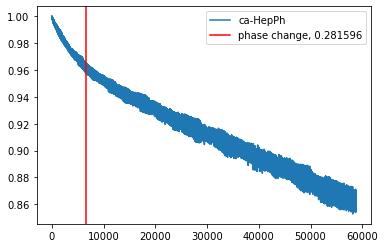

musae_facebook 0.903689359308069 20733.9442866751 0.34112932815942754 85411.5


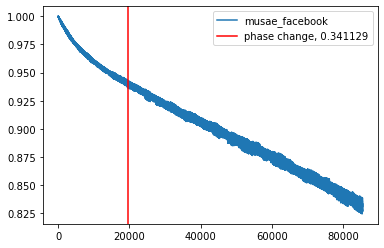

musae_git 0.8778468709675669 19232.56411956253 0.36205420481332723 144501.5


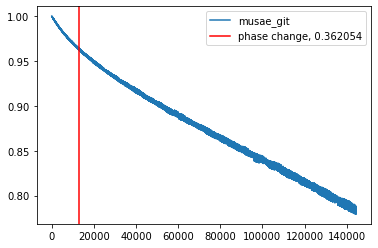

email_enron 0.8478536506478468 12057.627605231766 0.2748107099813306 91915.5


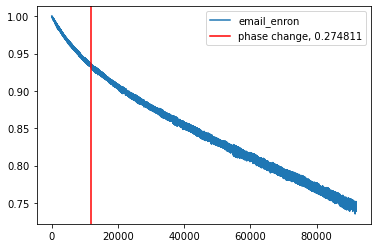

email_auall 0.692115423056067 5748.6923414770135 0.18861174974700412 182240.5


gnutella08 0.7751371358330373 2853.35582051247 0.26511560362962533 10388.5


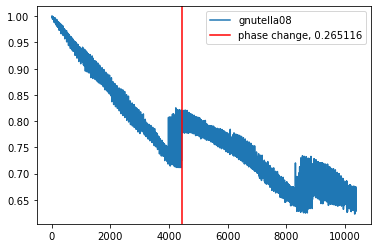

webspam 0.898864807522034 3861.3860299658295 0.3656612842941281 18687.5


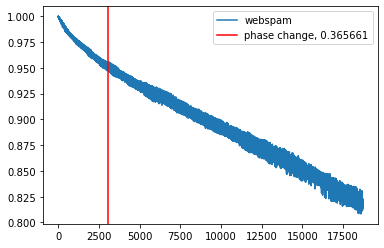

whois 0.8815268060442489 7113.978673342893 0.430352482665945 28471.5


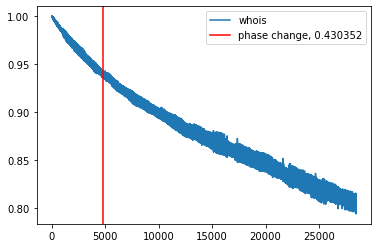

dmela 0.8399367773612644 2901.083745788953 0.3075749410388193 12784.5


tech_pgp 0.8168365564251647 2051.172158064589 0.19702528568508645 12158.0


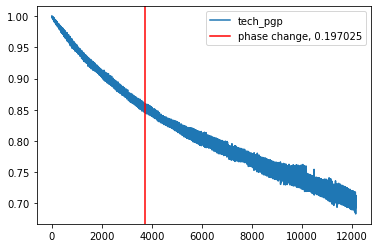

openflights 0.8902057798623472 1443.451889776678 0.29158403259827825 7838.5


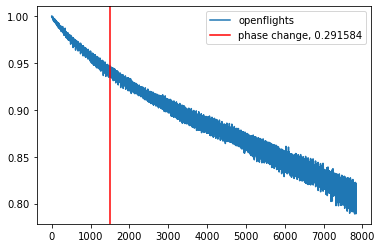

hamsterer 0.8694641787034271 2088.623618822571 0.3739086596459095 8315.0


arena 0.8421405917829898 454.89232342792144 0.37530649724288717 1371.0


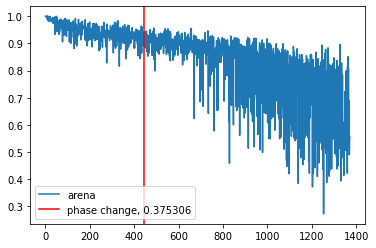

oregon 0.6771451120821065 630.5177881398178 0.13626643451941445 11001.0


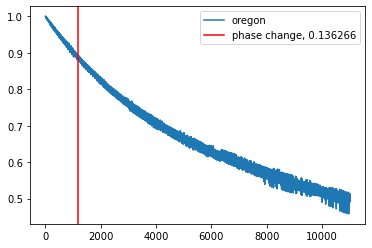

ca_grq 0.8012081678904394 699.7163526883376 0.14948090654291443 6711.0


tech_routers 0.8610520450223329 645.6532915860166 0.24591123522806196 3316.0


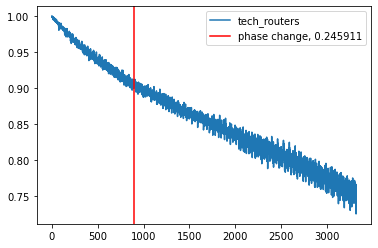

auto_as19971108 0.6282545526676083 161.16145105090146 0.10884838245232122 2578.0


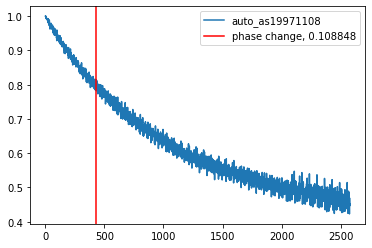

auto_as19980318 0.6392371878378247 212.5069876181948 0.1194160256050188 3084.0


GrQc 0.8012046461024224 711.8567301252078 0.15220964529581946 6711.0


moreno_innovation 0.42381193233766234 142.75853366232198 0.3230305217980213 461.5


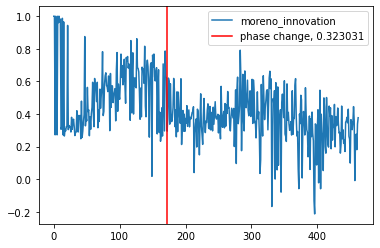

netscience 0.7077579134296177 40.197008118014544 0.08536608173035266 1371.0


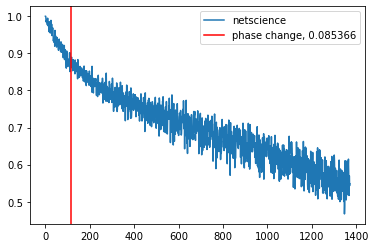

norwegian 0.6463954420404037 43.912989647314525 0.0569348664888255 1927.5


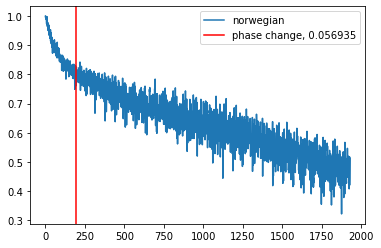

wiki 0.8079483577697797 371.6066863757925 0.3005653401592548 1457.0


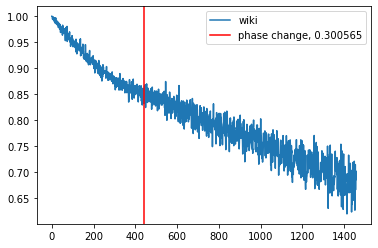

auto_as19990111 0.7697803383780528 60.28259836137982 0.15471008008648415 624.5


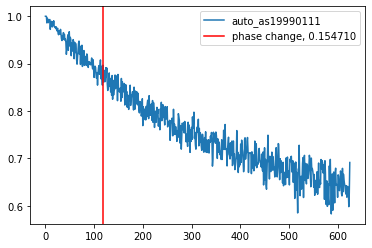

auto_as19990309 0.6485240035499398 266.0902494800987 0.11756611603130604 4448.0


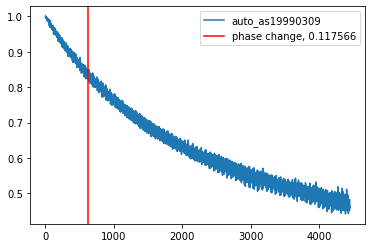

erdos 0.7841194832252787 312.49533021549115 0.14244769949082733 3757.5


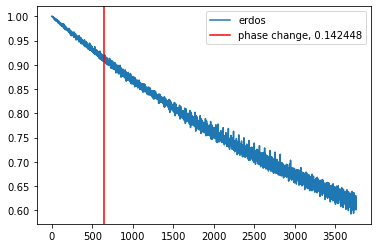

protein 0.6949674057872585 125.0426973640791 0.12258231354987638 1101.5


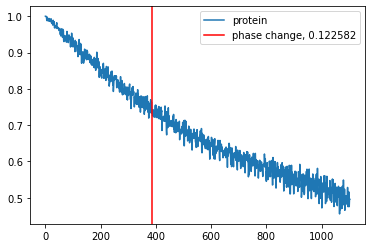

inf-power 0.38476194945367037 406.2622337820846 0.12395736689002641 3297.0


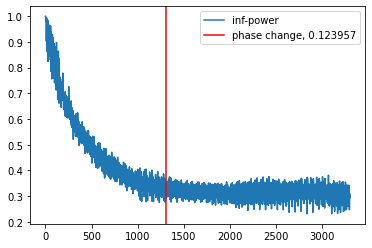

In [633]:
for i,r in df_ce3.iterrows():
    plt.plot(r['histories'], label = r['gr_name'])
    plt.legend()
    print(r['gr_name'],r['kres'],r['est'],r['est_norm'],r['edges']*0.5)
    plt.axvline(x = r['edges']-r['adj_size'], color = 'r', label = 'phase change, {:2f}'.format(r['est_norm']))
    plt.legend()
    plt.show()

ca-HepPh 0.9162144120684933 7238.80050491993 0.2815956499094917 58809.5 0.943016280545793


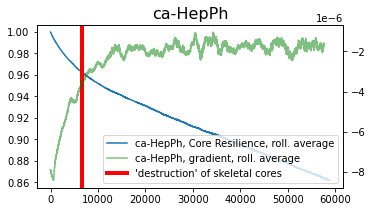

musae_facebook 0.903689359308069 20733.9442866751 0.34112932815942754 85411.5 0.8854896588871182


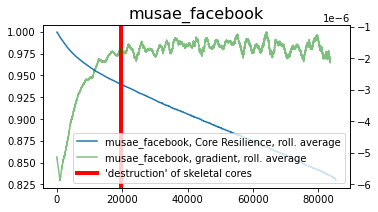

musae_git 0.8778468709675669 19232.56411956253 0.36205420481332723 144501.5 0.9549001221445292


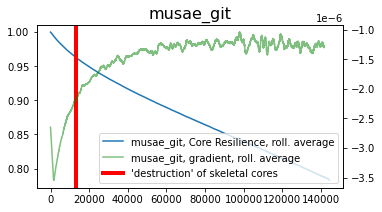

email_enron 0.8478536506478468 12057.627605231766 0.2748107099813306 91915.5 0.9356746141841386


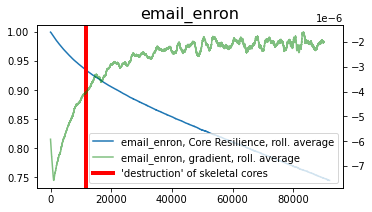

email_auall 0.692115423056067 5748.6923414770135 0.18861174974700412 182240.5 0.9836118663228899


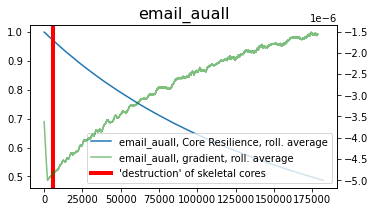

gnutella08 0.7751371358330373 2853.35582051247 0.26511560362962533 10388.5 0.7867834624345394


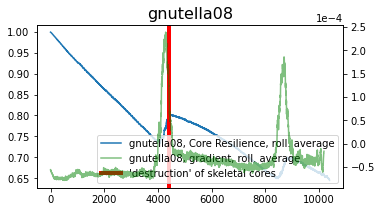

webspam 0.898864807522034 3861.3860299658295 0.3656612842941281 18687.5 0.9184213748535861


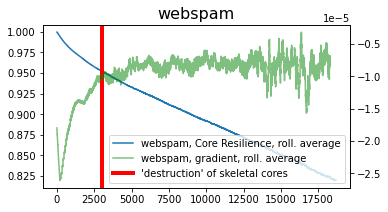

whois 0.8815268060442489 7113.978673342893 0.430352482665945 28471.5 0.9151791103244309


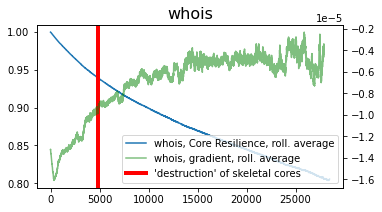

dmela 0.8399367773612644 2901.083745788953 0.3075749410388193 12784.5 0.8789158763031268


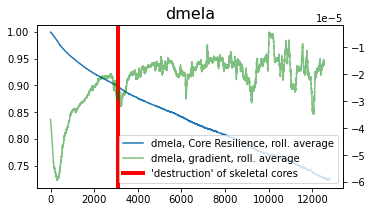

tech_pgp 0.8168365564251647 2051.172158064589 0.19702528568508645 12158.0 0.8467675442135718


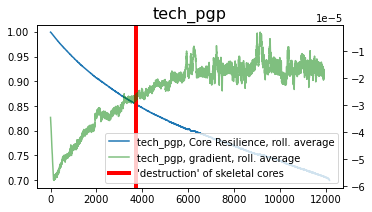

openflights 0.8902057798623472 1443.451889776678 0.29158403259827825 7838.5 0.9041230484184052


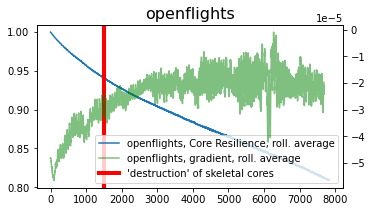

hamsterer 0.8694641787034271 2088.623618822571 0.3739086596459095 8315.0 0.8949488875516691


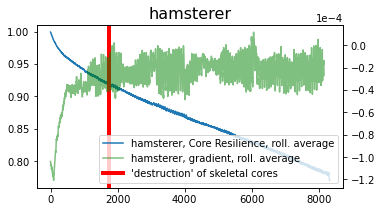

arena 0.8421405917829898 454.89232342792144 0.37530649724288717 1371.0 0.8379232784547859


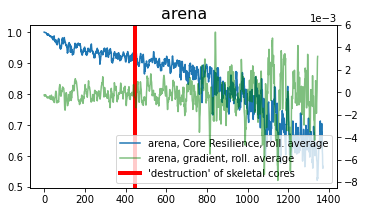

oregon 0.6771451120821065 630.5177881398178 0.13626643451941445 11001.0 0.9458852673116281


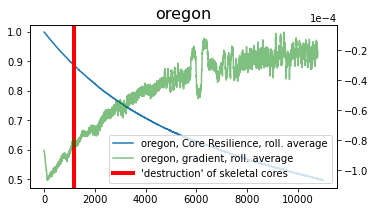

ca_grq 0.8012081678904394 699.7163526883376 0.14948090654291443 6711.0 0.8887952620363985


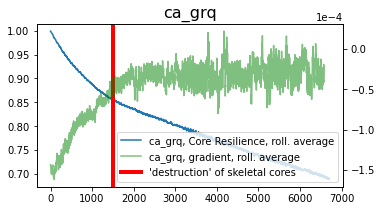

tech_routers 0.8610520450223329 645.6532915860166 0.24591123522806196 3316.0 0.8645976401795598


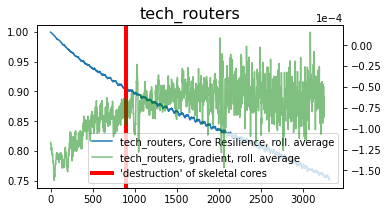

auto_as19971108 0.6282545526676083 161.16145105090146 0.10884838245232122 2578.0 0.9164052166438511


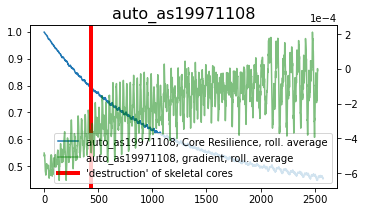

auto_as19980318 0.6392371878378247 212.5069876181948 0.1194160256050188 3084.0 0.9157146772437572


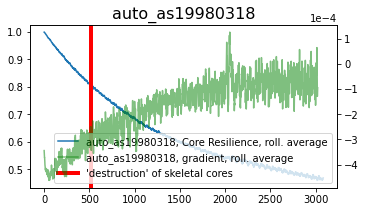

GrQc 0.8012046461024224 711.8567301252078 0.15220964529581946 6711.0 0.8889882282684923


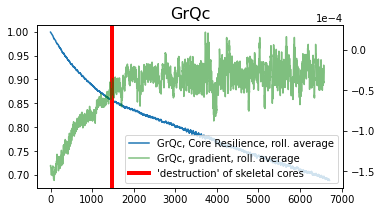

moreno_innovation 0.42381193233766234 142.75853366232198 0.3230305217980213 461.5 0.8136147560694668


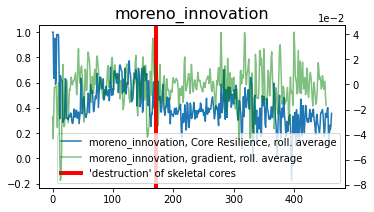

netscience 0.7077579134296177 40.197008118014544 0.08536608173035266 1371.0 0.9584721654211815


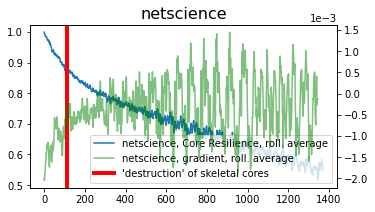

norwegian 0.6463954420404037 43.912989647314525 0.0569348664888255 1927.5 0.9494121519530633


wiki 0.8079483577697797 371.6066863757925 0.3005653401592548 1457.0 0.848361624198772


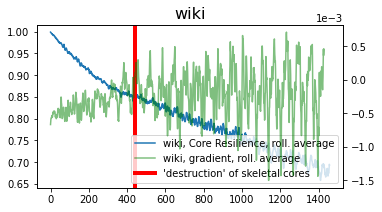

auto_as19990111 0.7697803383780528 60.28259836137982 0.15471008008648415 624.5 0.9049282445725082


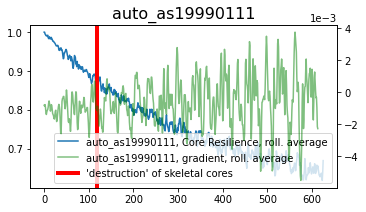

auto_as19990309 0.6485240035499398 266.0902494800987 0.11756611603130604 4448.0 0.9295225415936899


erdos 0.7841194832252787 312.49533021549115 0.14244769949082733 3757.5 0.9144368022547298


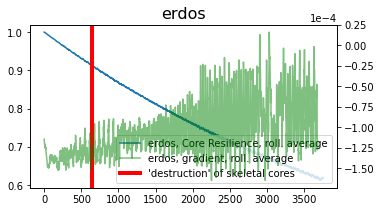

protein 0.6949674057872585 125.0426973640791 0.12258231354987638 1101.5 0.8247840645679791


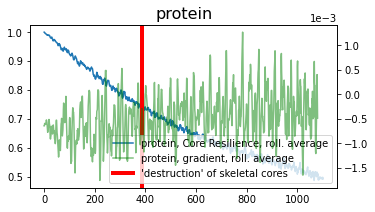

inf-power 0.38476194945367037 406.2622337820846 0.12395736689002641 3297.0 0.8019527413887377


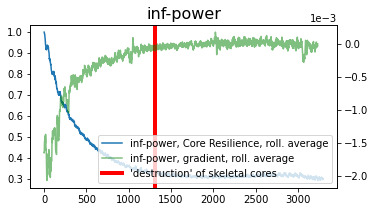

In [662]:
import matplotlib.pyplot as plt

df_ce3['histories_smoothed'] = df_ce3['histories'].apply(lambda x: uniform_filter1d(x, int(0.005*len(x)), mode='nearest'))
df_ce3['histories_gradient'] = df_ce3['histories_smoothed'].apply(np.gradient).apply(lambda x: uniform_filter1d(x, int(0.02*len(x)), mode='nearest'))#.apply(np.gradient).apply(lambda x: moving_average(x, int(0.25*len(x))))#.apply(lambda x: moving_average(x, int(0.1*len(x)))).apply(np.gradient)
for i,r in df_ce3.iterrows():
    fig, ax = plt.subplots(1,1,figsize=(5.5,3))
    lns1 = plt.plot(r['histories_smoothed'], label = "{}, Core Resilience, roll. average".format(r['gr_name']))
    ax2 = ax.twinx() 
    lns2 = ax2.plot(r['histories_gradient'][:-int(0.02*len(r['histories_gradient']))], label = "{}, gradient, roll. average ".format(r['gr_name']), color='green', alpha=0.5)
#     plt.plot(r['histories_gradient'], label = "{}, deriv.".format(r['gr_name']))
    print(r['gr_name'],r['kres'],r['est'],r['est_norm'],r['edges']*0.5,r['adj_size']/r['edges'])
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    lns3 = ax.axvline(x = r['edges']-r['adj_size'], color = 'r', lw=4 ,label = '\'destruction\' of skeletal cores')#, {:2f}'.format(r['est_norm']))
    lns = [lns1[0],lns2[0],lns3]
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower right')
    plt.title(r['gr_name'], fontsize=16)
#     ax.legend()
#     ax2.legend(loc ='lower right')
    plt.savefig('phase_plots/{}.png'.format(r['gr_name']),bbox_inches='tight', pad_inches=0.05)
    plt.show()

In [648]:
# !mkdir phase_plots

ca-HepPh 0.9162144120684933 6702.368098484367 0.2815956499094917 58809.5


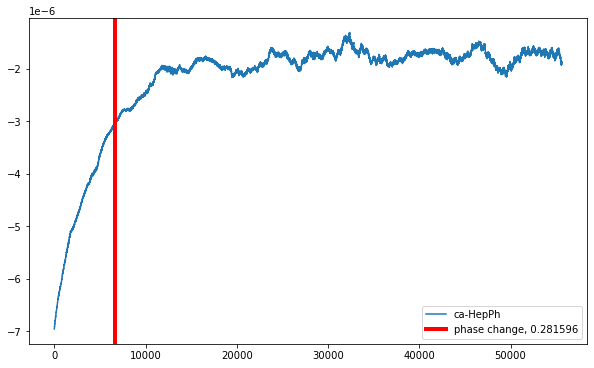

musae_facebook 0.903689359308069 19560.999999925814 0.34112932815942754 85411.5


musae_git 0.8778468709675669 13033.999999864609 0.36205420481332723 144501.5


email_enron 0.8478536506478468 11824.999999915628 0.2748107099813306 91915.5


email_auall 0.692115423056067 5973.1633507667575 0.18861174974700412 182240.5


gnutella08 0.7751371358330373 4430.000000997574 0.26511560362962533 10388.5


webspam 0.898864807522034 3049.0011148472186 0.3656612842941281 18687.5


whois 0.8815268060442489 4829.955920795932 0.430352482665945 28471.5


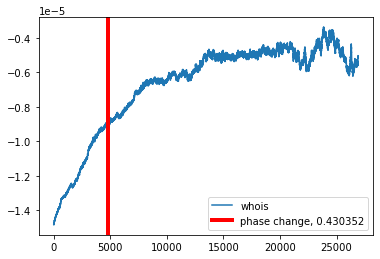

dmela 0.8399367773612644 3095.9999588053506 0.3075749410388193 12784.5


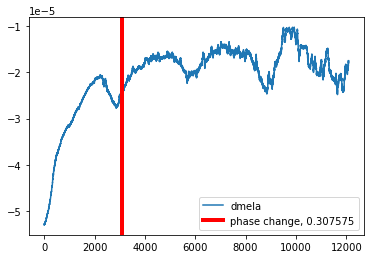

tech_pgp 0.8168365564251647 3726.0003949027887 0.19702528568508645 12158.0


openflights 0.8902057798623472 1503.0629699446617 0.29158403259827825 7838.5


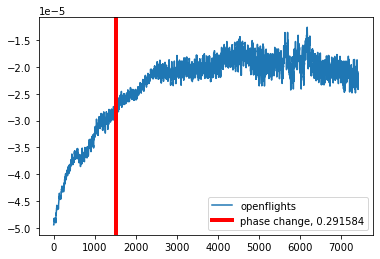

hamsterer 0.8694641787034271 1747.0000000157434 0.3739086596459095 8315.0


arena 0.8421405917829898 444.4143704769772 0.37530649724288717 1371.0


oregon 0.6771451120821065 1190.632348609557 0.13626643451941445 11001.0


ca_grq 0.8012081678904394 1492.58999294746 0.14948090654291443 6711.0


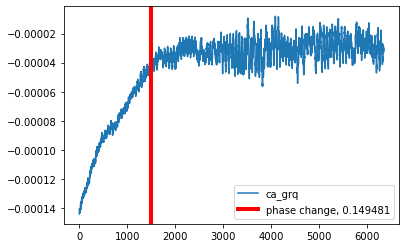

tech_routers 0.8610520450223329 897.9884503291596 0.24591123522806196 3316.0


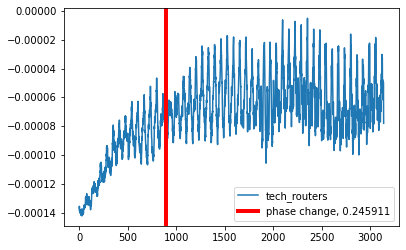

auto_as19971108 0.6282545526676083 431.01470298430377 0.10884838245232122 2578.0


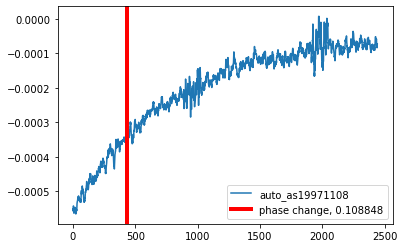

auto_as19980318 0.6392371878378247 519.8718707605058 0.1194160256050188 3084.0


GrQc 0.8012046461024224 1490.0000001802964 0.15220964529581946 6711.0


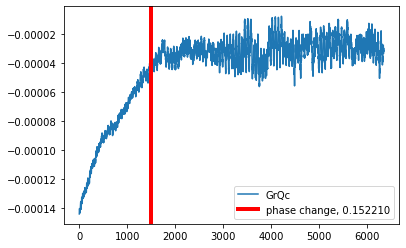

moreno_innovation 0.42381193233766234 172.03358014788216 0.3230305217980213 461.5


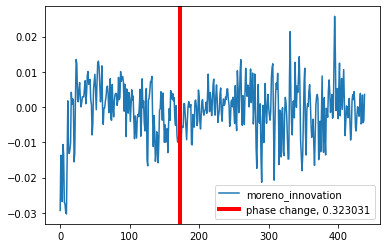

netscience 0.7077579134296177 113.86932241512022 0.08536608173035266 1371.0


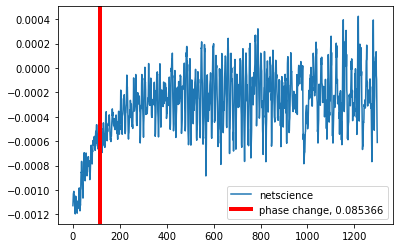

norwegian 0.6463954420404037 195.0161542209412 0.0569348664888255 1927.5


wiki 0.8079483577697797 441.87422708477834 0.3005653401592548 1457.0


auto_as19990111 0.7697803383780528 118.74462252893727 0.15471008008648415 624.5


auto_as19990309 0.6485240035499398 626.9674699825355 0.11756611603130604 4448.0


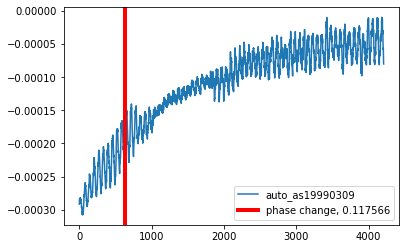

erdos 0.7841194832252787 643.0074310557056 0.14244769949082733 3757.5


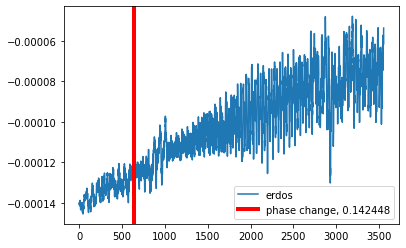

protein 0.6949674057872585 386.00070575674204 0.12258231354987638 1101.5


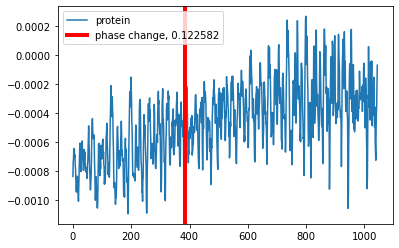

inf-power 0.38476194945367037 1305.9236232826634 0.12395736689002641 3297.0


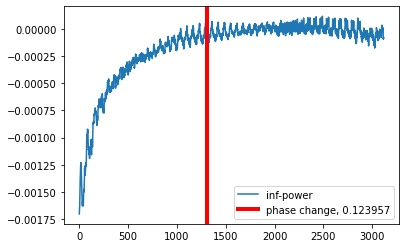

In [594]:
figure(figsize=(10,6))
df_ce3['histories_diff'] = df_ce3['histories_smoothed'].apply(np.diff)
df_ce3['histories_smoothed_diff'] = df_ce3['histories_diff'].apply(lambda x: moving_average(x, int(0.05*len(x))))
# df_ce3['histories_cumsum'] = df_ce3['histories'].apply(lambda x:np.cumsum(x))
for i,r in df_ce3.iterrows():
    plt.plot(r['histories_smoothed_diff'], label = r['gr_name'])
    plt.axvline(x = r['edges']-r['adj_size'], lw=4, color = 'r', label = 'phase change, {:2f}'.format(r['est_norm']))
    plt.legend()
    print(r['gr_name'],r['kres'],r['edges']-r['adj_size'],r['est_norm'],r['edges']*0.5)
    plt.show()

In [497]:
df_ce3 = df_ce2.copy() #.iloc[1:].copy()
df_ce3['kres_orig'] = df_ce3['gr_name'].apply(lambda x:kcore_res.get(x,0))
# df_ce3['est_norm'] = df_ce3['est']/df_ce3['est_size']

df_ce3 = df_ce3[df_ce3['gr_name']!="moreno_oz"]
df_ce3

[[ 1.         -0.24927788]
 [-0.24927788  1.        ]]
[[ 1.         -0.28389076]
 [-0.28389076  1.        ]]
[[1.         0.42495447]
 [0.42495447 1.        ]]
[[1.         0.26167678]
 [0.26167678 1.        ]]


gr_name   ce_orig    ce_new           est   est_size  \
0            ca-HepPh  0.072451  0.071304   7238.800505  110925.36   
1      musae_facebook  0.116561  0.115477  20733.944287  151252.68   
2           musae_git  0.590154  0.587753  19232.564120  275978.28   
3         email_enron  0.446398  0.443165  12057.627605  171981.90   
4         email_auall  0.000000  0.000000   5748.692341  358501.20   
5          gnutella08  0.249069  0.247317   2853.355821   16312.62   
6             webspam  0.387653  0.385079   3861.386030   34310.94   
7               whois  0.348032  0.346189   7113.978673   52131.08   
8               dmela  0.454886  0.448974   2901.083746   22473.52   
9            tech_pgp  0.070772  0.068175   2051.172158   20578.24   
10        openflights  0.416606  0.412469   1443.451890   14177.14   
11          hamsterer  0.268718  0.265207   2088.623619   14871.70   
13              arena  0.217055  0.215752    454.892323    2297.30   
14             oregon  0.560211  0.556040    630.517788   20810.86   
15             ca_grq  0.044641  0.043168    699.716353   11926.54   
16       tech_routers  0.247871  0.242637    645.653292    5730.02   
17    auto_as19971108  0.520862  0.513362    161.161451    4717.10   
18    auto_as19980318  0.506315  0.499118    212.506988    5649.18   
19               GrQc  0.044641  0.043168    711.856730   11927.22   
20  moreno_innovation  0.241120  0.236528    142.758534     746.06   
21         netscience  0.021539  0.020995     40.197008    2626.42   
22          norwegian  0.032970  0.030960     43.912990    3656.98   
23               wiki  0.365380  0.358818    371.606686    2465.42   
24    auto_as19990111  0.464807  0.453553     60.282598    1130.46   
25    auto_as19990309  0.482867  0.476998    266.090249    8271.80   
26              erdos  0.368333  0.367018    312.495330    6864.30   
27            protein  0.000000  0.000000    125.042697    1815.76   
28          inf-power  0.059408  0.056997    406.262234    5285.90   

         adj_size   edges   nodes      est_norm  \
0   110916.631902  117619   11204  25681.103068   
1   151262.000000  170823   22470  60800.755700   
2   275969.000000  289003   37700  53093.198560   
3   172006.000000  183831   36692  43943.023324   
4   358507.836649  364481  265214  30503.536174   
5    16346.999999   20777    6301  10806.899231   
6    34325.998885   37375    4767  10596.276491   
7    52113.044079   56943    7476  16487.736660   
8    22473.000041   25569    7393   9432.119977   
9    20589.999605   24316   10680  10429.485483   
10   14173.937030   15677    2939   4941.402894   
11   14883.000000   16630    2426   5609.436465   
13    2297.585630    2742     198   1212.055551   
14   20811.367651   22002   10670   4629.955218   
15   11929.410007   13422    4158   4687.205061   
16    5734.011550    6632    2113   2632.958092   
17    4724.985297    5156    3015   1497.279933   
18    5648.128129    6168    3455   1777.166264   
19   11932.000000   13422    4158   4685.129051   
20     750.966420     923     241    447.736929   
21    2628.130678    2742    1461    477.127034   
22    3659.983846    3855    1421    780.033909   
23    2472.125773    2914     889   1248.337891   
24    1130.255377    1249     549    389.648808   
25    8269.032530    8896    4759   2258.163715   
26    6871.992569    7515    5094   2210.280036   
27    1816.999294    2203    1870   1021.614665   
28    5288.076377    6594    4941   3281.625425   

                                            histories  ...      cis95  \
0   [1.0, 0.9999948062649816, 1.0, 0.9999831965890...  ...   4.247772   
1   [1.0, 1.0, 0.9999912397500139, 0.9999209305341...  ...   8.049822   
2   [1.0, 0.9999651062435669, 0.9999903471650191, ...  ...   7.106631   
3   [1.0, 0.9999694485693057, 0.9999995235712824, ...  ...   6.765123   
4   [1.0, 0.9999994236474931, 0.9999843314282274, ...  ...   1.077652   
5   [1.0, 1.0, 0.9998830209932963, 0.9998117648832...  ...   3.68

In [402]:
df_ce3.sort_values(by='est')

gr_name   ce_orig    ce_new           est   est_size  \
21         netscience  0.021539  0.020995     40.197008    2626.42   
22          norwegian  0.032970  0.030960     43.912990    3656.98   
24    auto_as19990111  0.464807  0.453553     60.282598    1130.46   
27            protein  0.000000  0.000000    125.042697    1815.76   
20  moreno_innovation  0.241120  0.236528    142.758534     746.06   
17    auto_as19971108  0.520862  0.513362    161.161451    4717.10   
18    auto_as19980318  0.506315  0.499118    212.506988    5649.18   
25    auto_as19990309  0.482867  0.476998    266.090249    8271.80   
26              erdos  0.368333  0.367018    312.495330    6864.30   
23               wiki  0.365380  0.358818    371.606686    2465.42   
28          inf-power  0.059408  0.056997    406.262234    5285.90   
13              arena  0.217055  0.215752    454.892323    2297.30   
14             oregon  0.560211  0.556040    630.517788   20810.86   
16       tech_routers  0.247871  0.242637    645.653292    5730.02   
15             ca_grq  0.044641  0.043168    699.716353   11926.54   
19               GrQc  0.044641  0.043168    711.856730   11927.22   
10        openflights  0.416606  0.412469   1443.451890   14177.14   
9            tech_pgp  0.070772  0.068175   2051.172158   20578.24   
11          hamsterer  0.268718  0.265207   2088.623619   14871.70   
5          gnutella08  0.249069  0.247317   2853.355821   16312.62   
8               dmela  0.454886  0.448974   2901.083746   22473.52   
6             webspam  0.387653  0.385079   3861.386030   34310.94   
4         email_auall  0.000000  0.000000   5748.692341  358501.20   
7               whois  0.348032  0.346189   7113.978673   52131.08   
0            ca-HepPh  0.072451  0.071304   7238.800505  110925.36   
3         email_enron  0.446398  0.443165  12057.627605  171981.90   
2           musae_git  0.590154  0.587753  19232.564120  275978.28   
1      musae_facebook  0.116561  0.115477  20733.944287  151252.68   

         adj_size   edges   nodes  est_norm  \
21    2628.130678    2742    1461  0.084248   
22    3659.983846    3855    1421  0.056296   
24    1130.255377    1249     549  0.154710   
27    1816.999294    2203    1870  0.122397   
20     750.966420     923     241  0.318845   
17    4724.985297    5156    3015  0.107636   
18    5648.128129    6168    3455  0.119576   
25    8269.032530    8896    4759  0.117835   
26    6871.992569    7515    5094  0.141383   
23    2472.125773    2914     889  0.297681   
28    5288.076377    6594    4941  0.123799   
13    2297.585630    2742     198  0.375306   
14   20811.367651   22002   10670  0.136182   
16    5734.011550    6632    2113  0.245220   
15   11929.410007   13422    4158  0.149282   
19   11932.000000   13422    4158  0.151940   
10   14173.937030   15677    2939  0.292114   
9    20589.999605   24316   10680  0.196671   
11   14883.000000   16630    2426  0.372341   
5    16346.999999   20777    6301  0.264031   
8    22473.000041   25569    7393  0.307575   
6    34325.998885   37375    4767  0.364410   
4   358507.836649  364481  265214  0.188460   
7    52113.044079   56943    7476  0.431471   
0   110916.631902  117619   11204  0.281873   
3   172006.000000  183831   36692  0.274392   
2   275969.000000  289003   37700  0.362242   
1   151262.000000  170823   22470  0.341015   

                                            histories      kres  kres_orig  \
21  [0.9999999999999999, 0.9999999999999999, 0.997...  0.707758       0.00   
22  [0.9999999999999999, 0.9960249257603446, 0.999...  0.646395       0.00   
24  [0.9999999999999998, 0.9999999999999998, 0.999...  0.769780       0.00   
27  [1.0, 1.0, 1.0, 0.9979542835968397, 0.99592466...  0.694967       0.00   
20  [1.0, 1.0, 0.27171153912527746, 1.0, 0.9021342...  0.423812       0.00   
17  [1.0, 0.9989267477945073, 1.0, 0.9986061117654...  0.628255       0.58   
18  [0.9999999999999999, 0.9999999999999999, 0.999...  0.639237       0.0

[[ 1.         -0.27360303]
 [-0.27360303  1.        ]]


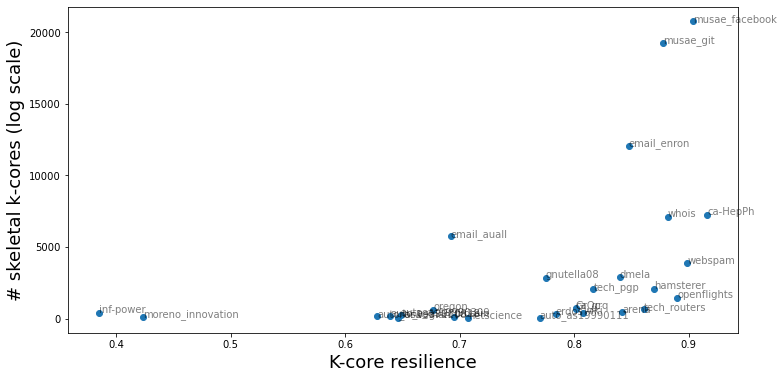

In [387]:
fig, ax = plt.subplots(figsize=(12,6))

ys = df_ce3['est'].tolist()
xs = df_ce3['kres'].tolist()
print(np.corrcoef(df_ce3['est'],df_ce3['kres_orig']))
plt.xlabel('K-core resilience', size=18)
plt.ylabel('# skeletal k-cores (log scale)', size=18)

for i, txt in enumerate(list(df_ce3['gr_name'])):
    t = ax.annotate(txt, (xs[i], ys[i]))
    t.set_alpha(.5)

ax.scatter(xs, ys)
# plt.savefig("paper_plots/kcore_resilience_vs_skeletal_num_paper.png",bbox_inches='tight')


plt.show()

[[1.         0.55805456]
 [0.55805456 1.        ]]


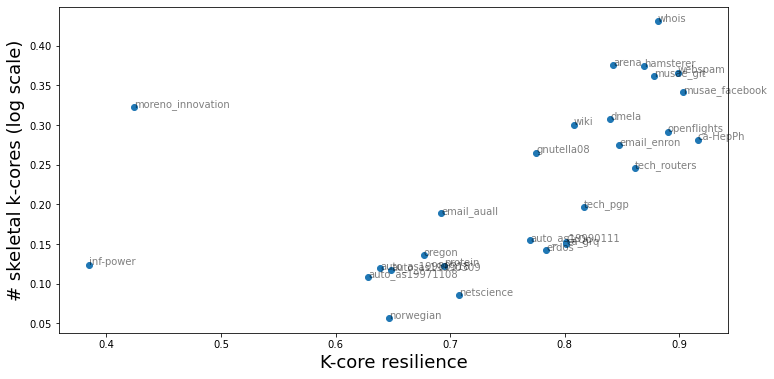

In [527]:
fig, ax = plt.subplots(figsize=(12,6))

ys = df_ce3['est_norm'].tolist()
xs = df_ce3['kres'].tolist()
print(np.corrcoef(xs,ys))
plt.xlabel('K-core resilience', size=18)
plt.ylabel('# skeletal k-cores (log scale)', size=18)

for i, txt in enumerate(list(df_ce3['gr_name'])):
    t = ax.annotate(txt, (xs[i], ys[i]))
    t.set_alpha(.5)

ax.scatter(xs, ys)
# plt.savefig("paper_plots/kcore_resilience_vs_skeletal_num_paper.png",bbox_inches='tight')


plt.show()